In [73]:
import gymnasium as gym
import pygame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import savgol_filter
from sympy.physics.units import temperature

q_table = None
env = gym.make("FrozenLake8x8-v1", is_slippery=True, render_mode="human")





## Reinforcement Learning

The **reinforcement learning** is a paradigm of machine learning that often relies on the interaction of **agent** and **environment**.


This is a diagram of the **Markov Decision Process**, which is the best friend of RL and probabilistic decision-making models in general. We'll refer to it as **MDP** for short.

---

### MDP

The **MDP** is described with:
- **States**: all possible states the agent could encounter, $s \in \mathcal{S}$
- **Actions**: set of possible actions, $a \in \mathcal{A}(s)$, for every state
- **Rewards**: set of rewards for $r = R(s) \in \mathbb{R}$, meaning all states have some reward (or none)

---

Also, to explain the main idea of the MDP, we should have **discrete time steps**:
$$ t \in \{0, 1, 2, \dots, n\}$$

MDP has an assumption that **previous steps don't affect the underlying probability distribution**, then it looks like:

$$
p(s', r \mid s, a)
$$

MDP defines the probability of getting new state $s'$ and receiving reward $r$ after taking action $a$ in state $s$.

MDP describes the **environment**, and the **agent** behavior is described within **policy**.

---

## Policy $\pi$

Policy $\pi(a \mid s)$ tells the **probability of taking a particular action** $a$ among $\mathcal{A}(s)$ when being in state $s$.

---

## Return $G_t$

Now we have defined the environment and agent and could even test the setup.

For this test, the authors (of the setup) follow the **uniform distribution** — this is called the **random policy**.

Now the agent is performing **random actions**, completing the **SARSA loop**, but now it is practically useless.
We need to introduce the way to **improve policy**.

---

### Return $G_t$

The return $G_t$ is **accumulated rewards over all future time steps**.
Also, we want to consider **closer rewards as more valuable** — for that, we add **discount factor** $\gamma$, so:

$$
G_t = \sum_{k=t+1}^{T} \gamma^{k - t - 1} R_k
$$

---

With the idea of return formalized, the **goal for optimal policy** might be described as **maximizing expected return**:

$$
\pi^* = \arg\max_{\pi} \mathbb{E}_\pi [G_t]
$$

---

## Bellman Equations

To make learning tractable, we need a way to break down the expected return into **recursive relationships**.
This is where the **Bellman equations** come in.

---

### State-Value Function $V_\pi(s)$

The **value function** measures the expected return from state $s$, following policy $\pi$:

$$
V_\pi(s) = \mathbb{E}_\pi \left[ G_t \mid S_t = s \right]
$$

Using the return definition, we can derive the **Bellman expectation equation**:

$$
V_\pi(s) = \sum_{a} \pi(a \mid s) \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma V_\pi(s') \right]
$$

---

### Action-Value Function $Q_\pi(s, a)$

Similarly, for action-value function — the expected return from taking action $a$ in state $s$ and then following policy $\pi$:

$$
Q_\pi(s, a) = \mathbb{E}_\pi \left[ G_t \mid S_t = s, A_t = a \right]
$$

Bellman expectation equation for $Q_\pi$ becomes:

$$
Q_\pi(s, a) = \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma \sum_{a'} \pi(a' \mid s') Q_\pi(s', a') \right]
$$

---

## Generalized Policy Iteration (GPI)

To find the optimal policy $\pi^*$, we can iteratively:
- **evaluate** a policy (compute $V_\pi$ or $Q_\pi$),
- then **improve** it by acting greedily with respect to the value function.

This loop is called **Generalized Policy Iteration (GPI)**.

---

### Policy Improvement Theorem

A new policy $\pi'$ that is greedy with respect to $V_\pi$ will always perform **at least as well**:

$$
\pi'(s) = \arg\max_a Q_\pi(s, a)
$$

If $\pi' \ne \pi$, then $V_{\pi'}(s) > V_\pi(s)$ for some $s$.

We repeat evaluation and improvement until convergence. This gives us the **optimal policy** $\pi^*$.

---

## Temporal Difference (TD) Learning

In real environments, we often don’t know the transition probabilities $p(s', r \mid s, a)$.
Instead, we **learn from experience** — this is where **TD learning** comes in.

---

### TD Target

Instead of waiting until the end to compute $G_t$, we use a **bootstrapped estimate**:

$$
\text{TD Target} = R_{t+1} + \gamma V(S_{t+1})
$$

Then we update our value function like this:

$$
V(S_t) \leftarrow V(S_t) + \alpha \left[ \text{TD Target} - V(S_t) \right]
$$

This difference is called the **TD error**:

$$
\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)
$$

---

TD learning is **online, model-free**, and **updates at each time step** — making it powerful for real-time RL tasks.

---

## Exploration Strategies

To learn effectively, the agent needs to **explore** the environment, not just exploit what it already knows.
This creates a fundamental trade-off:
> **Exploration vs Exploitation**

---

### $\varepsilon$-Greedy Strategy

One of the simplest strategies:

- With probability $\varepsilon$, pick a **random action** (exploration).
- With probability $1 - \varepsilon$, pick the **greedy action** (exploitation):

$$
a =
\begin{cases}
\text{random action}, & \text{with prob } \varepsilon \\
\arg\max_a Q(s, a), & \text{with prob } 1 - \varepsilon
\end{cases}
$$

Often $\varepsilon$ decays over time (e.g., $\varepsilon_t = \varepsilon_0 \cdot \exp(-kt)$), so exploration decreases as the agent learns more.

---

### Boltzmann (Softmax) Exploration

Instead of hard choices, Boltzmann (or **softmax**) exploration **samples actions according to their estimated values**.

Probability of taking action $a$ in state $s$:

$$
\pi(a \mid s) = \frac{\exp\left( Q(s, a) / \tau \right)}{\sum_{a'} \exp\left( Q(s, a') / \tau \right)}
$$

Where:

- $\tau$ is the **temperature** parameter.
  - High $\tau$: more uniform distribution (more exploration).
  - Low $\tau$: more greedy (exploitation).

---

### Intuition Behind Boltzmann

- Boltzmann is smoother than $\varepsilon$-greedy — **more nuanced**.
- It gives **better control** over the exploration spectrum.
- With appropriate tuning of $\tau$, the agent can **gradually shift** from exploring to exploiting.


In [39]:
def run(q_table, episodes = 1, is_slippery = True):
    pygame.init()
    env = gym.make("FrozenLake8x8-v1", is_slippery=is_slippery, render_mode="human")
    policy = q_table

    action_map = {
        0: "LEFT",
        1: "DOWN",
        2: "RIGHT",
        3: "UP"
    }

    for i in range(episodes):
        state = env.reset()[0]
        print(f"Initial state is [{state // 8}, {state % 8}]")
        terminated = False
        truncated = False

        while(not terminated and not truncated):
            action_space = policy[state]
            action = np.argmax(action_space)
            print(f"Action is [{action}]")
            print(f"Action is {action_map[action]}]")
            new_state, reward, terminated, truncated,_ = env.step(action)

            state = new_state

            print(f"New state is [{new_state // 8}, {new_state % 8}], reward is {reward}")

    env.close()

    pygame.quit()

first run with random policy

In [3]:
q_random = np.random.rand(env.observation_space.n, env.action_space.n)

run(q_random ,episodes = 1)

Initial state is [0, 0]
Action is [0]
Action is LEFT]
New state is [0, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [0, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [0, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [1, 0], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [0, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [1, 0], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [2, 0], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [3, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [3, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [2, 0], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [3, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [3, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [3, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [2, 0], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [2, 1], reward is 

In [78]:
def plot_q_table(q_table, episode = None):
    values = q_table.max(axis=1)

    # values = q_table.mean(axis=1)

    values_grid = values.reshape(8,8)

    plt.imshow(
        values_grid,
        origin='upper',
        extent=[0, 8, 0, 8],
        interpolation='nearest',
        aspect='equal'
    )
    plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)

    holes = [(5,3), (3,3), (4,5),(2,2), (2,1), (1,1), (0,3), (1,4), (1,6), (2,6)]

    ax = plt.gca()
    for (row, col) in holes:
        rect = plt.Rectangle(
                (col, row),
                1, 1,
                fill=True,
                color='red',
                alpha=1
            )
        ax.add_patch(rect)

    rect = plt.Rectangle(
                (7, 0),
                1, 1,
                fill=True,
                color='green',
                alpha=1
            )
    ax.add_patch(rect)

    rect = plt.Rectangle(
                (0, 7),
                1, 1,
                fill=True,
                color='green',
                alpha=1
            )
    ax.add_patch(rect)

    plt.title("Value table" + f"at step #{episode}" if episode is not None else "")
    plt.colorbar()
    plt.show()




    actions = q_table.argmax(axis=1)

    actions_grid = actions.reshape(8,8)

    plt.imshow(
        values_grid,
        origin='upper',
        extent=[0, 8, 0, 8],
        interpolation='nearest',
        aspect='equal'
    )
    plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)

    holes = [(5,3), (3,3), (4,5),(2,2), (2,1), (1,1), (0,3), (1,4), (1,6), (2,6)]

    ax = plt.gca()
    for (row, col) in holes:
        rect = plt.Rectangle(
                (col, row),
                1, 1,
                fill=True,
                color='red',
                alpha=1
            )
        ax.add_patch(rect)

    rect = plt.Rectangle(
                (7, 0),
                1, 1,
                fill=True,
                color='green',
                alpha=1
            )
    ax.add_patch(rect)

    rect = plt.Rectangle(
                (0, 7),
                1, 1,
                fill=True,
                color='green',
                alpha=1
            )
    ax.add_patch(rect)

    for y in range(8):
        for x in range(8):
            # (0,0)  (y,x)-> (0, 7)(x, 7 - y)

            action = actions_grid[y, x]

            match action:
                case 0:
                    # top
                    start_y, start_x ,arrow_x, arrow_y = 0.2, 0.5, 0 , 0.2
                case 1:
                    # bot
                    start_y, start_x ,arrow_x, arrow_y = 0.8, 0.5, 0 , -0.2
                case 2:
                    # right
                    start_y, start_x ,arrow_x, arrow_y = 0.5, 0.2 , 0.2 , 0
                case 3:
                    # left
                    start_y, start_x ,arrow_x, arrow_y = 0.5, 0.8 , -0.2 , 0
                case _:
                    print("Unknown action")


            plt.arrow(x + start_x, 7 - y + start_y, arrow_x, arrow_y, width = 0.1)

    plt.title("Policy table" + f"at step #{episode}" if episode is not None else "")
    plt.colorbar()
    plt.show()

def train(
        episodes=4000,
        lr=1e-2,
        gamma=0.9,
        td_num=4,
        cost_of_living=0.01,
        T=100,
        render=True,
        isSlippery=True,
        label="base",
        draw_q_table=None,
        truncated_penalty=0,
        exploration_strategy = "boltzmann",
        temperature = 2,):

    if draw_q_table is None:
        draw_q_table = range(episodes // 5, episodes, episodes // 5)

    pygame.init()
    global q_table
    env = gym.make("FrozenLake8x8-v1", is_slippery=isSlippery)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    epsilon = 1
    epsilon_decay = 1/(episodes * 0.9)
    rewards_per_episode = np.zeros(episodes)
    time_rewards_per_episode = np.zeros(episodes)
    success_rate = np.zeros(episodes)
    steps_per_episode = []

    for episode in range(episodes):
        trajectory = []
        state = env.reset()[0]
        steps = 0
        total_reward = 0

        for t in range(T):

            if epsilon != 0:
                if exploration_strategy == "epsilon":
                    if np.random.random() < epsilon:
                        action = env.action_space.sample()

                elif exploration_strategy == "boltzmann":
                    if epsilon != 0:
                        preferences = q_table[state] / temperature
                        # prevent overflow
                        max_pref = np.max(preferences)
                        exp_prefs = np.exp((preferences - max_pref)/ temperature)
                        probs = exp_prefs / np.sum(exp_prefs)
                        action = np.random.choice(len(probs), p=probs)
            else:
                action = np.argmax(q_table[state])

            new_state, reward, terminated, truncated, _ = env.step(action)
            steps += 1

            # Adjust reward for falling into a hole
            if (terminated) and (reward == 0):
                reward = reward - 1

            if reward == 1:
                success_rate[episode] = 1.0
                time_rewards_per_episode[episode] = 1
                steps_per_episode.append(steps)
                reward = reward - cost_of_living * steps

            # episode truncated
            if t == 99:
                reward = reward - truncated_penalty

            reward -= cost_of_living

            total_reward += reward

            # Store transition with termination info
            trajectory.append((state, action, reward, new_state, terminated))

            # Process n-step updates
            while len(trajectory) >= td_num:
                # Pop the oldest transition
                oldest_state, oldest_action, oldest_reward, oldest_new_state, oldest_terminated = trajectory.pop(0)

                G = oldest_reward
                current_gamma = gamma
                term_in_window = oldest_terminated

                # Sum rewards for next (td_num-1) steps or until termination
                for k in range(1, td_num):
                    if (k-1) >= len(trajectory):
                        break
                    entry = trajectory[k-1]
                    r_k, term_k = entry[2], entry[4]
                    G += current_gamma * r_k
                    current_gamma *= gamma
                    if term_k:
                        term_in_window = True
                        break

                # Add discounted Q-value if no termination in the window
                if not term_in_window and len(trajectory) >= (td_num-1):
                    last_entry = trajectory[td_num-2]  if td_num != 1 else (oldest_state, oldest_action, oldest_reward, oldest_new_state, oldest_terminated)
                    last_state = last_entry[3]
                    if not last_entry[4]:
                        G += current_gamma * np.max(q_table[last_state])

                # Update Q-value
                q_table[oldest_state][oldest_action] += lr * (G - q_table[oldest_state][oldest_action])

            state = new_state
            if terminated or truncated:
                break

        # Process remaining transitions after episode ends
        while len(trajectory) > 0:

            oldest_entry = trajectory.pop(0)
            s, a, r, s_new, term = oldest_entry

            G = r
            current_gamma = gamma

            for k in range(1, len(trajectory)+1):
                if (k-1) >= len(trajectory):
                    break
                entry = trajectory[k-1]
                r_k, term_k = entry[2], entry[4]
                G += current_gamma * r_k
                current_gamma *= gamma

            # No Q-value added after episode termination
            q_table[s][a] += lr * (G - q_table[s][a])

        # Decay exploration and learning rate
        epsilon = max(epsilon - epsilon_decay, 0)
        rewards_per_episode[episode] = total_reward
        # if epsilon == 0:
        #     lr *= 0.1  # Decay learning rate after exploration stops

        # print(f"Episode {episode} | Reward: {rewards_per_episode[episode]} | Epsilon: {epsilon}")

        if render and (episode in draw_q_table):
            print("__________________________________")
            plot_q_table(q_table, episode)

    env.close()
    pygame.quit()

    print("__________________________________")
    print("Learning curve")
    if render:
        plt.plot(rewards_per_episode)

    moving_average_window = episodes // 10
    moving_averages = savgol_filter(rewards_per_episode, moving_average_window, 5)


    plt.plot(moving_averages, label=f'{label}')
    plt.title(label)
    plt.legend()
    if render:
        plt.show()

    print("__________________________________")
    print(f"{label}")
    mean_reward_rate = np.mean(rewards_per_episode[int(len(rewards_per_episode)*0.9):])
    mean_success_rate = np.mean(success_rate[int(len(success_rate)*0.9):])
    print(f"Mean reward: {mean_reward_rate}")
    print(f"Mean success rate: {mean_success_rate}")
    if steps_per_episode:
        mean_steps = np.mean(steps_per_episode[int(len(steps_per_episode)*0.9):])
        print(f"Mean steps per success episode: {mean_steps}")
    else:
        print("No successful episodes to calculate mean steps.")
    if render:
        print("__________________________________")
        print("Final Q_Table:")
        plot_q_table(q_table)

    return mean_success_rate

firstly test if the train function is working properly

__________________________________


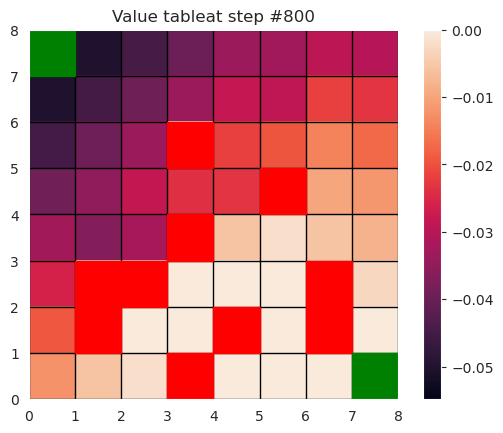

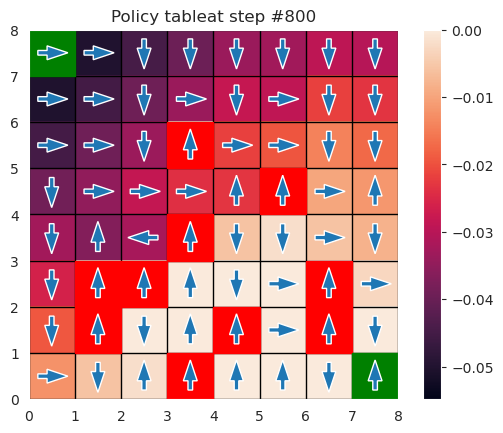

__________________________________


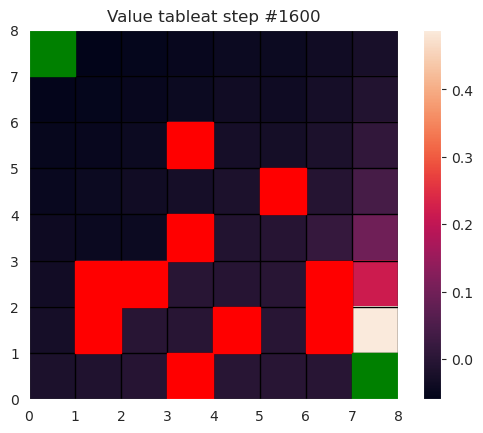

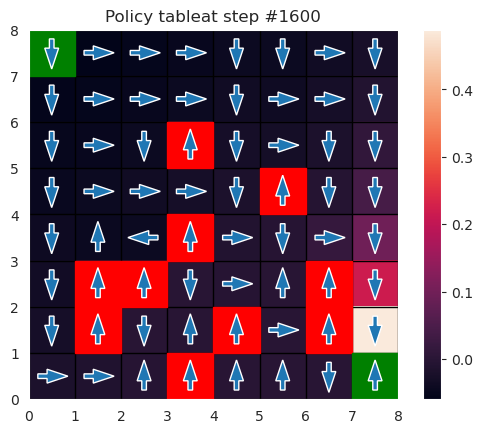

__________________________________


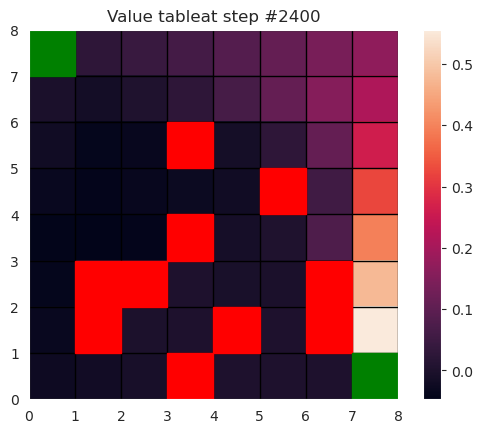

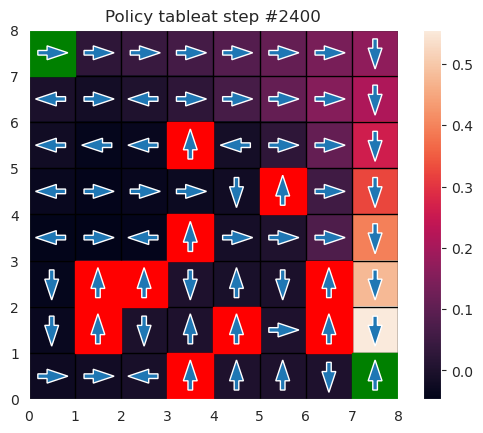

__________________________________


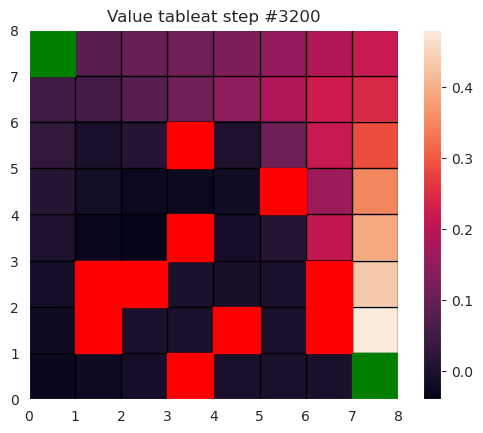

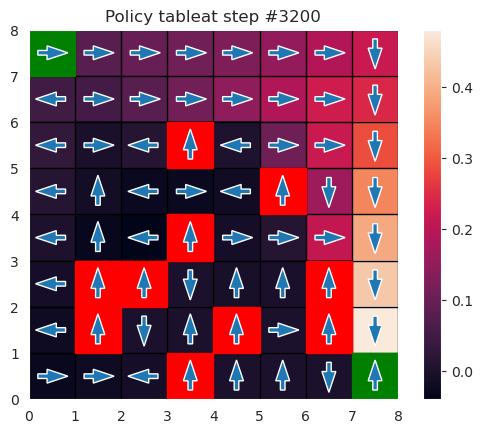

__________________________________
Learning curve


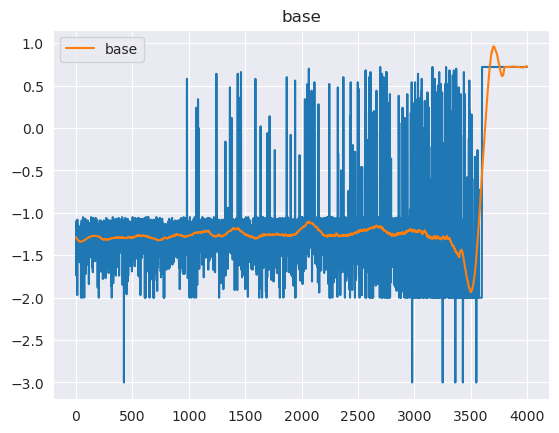

__________________________________
base
Mean reward: 0.71815
Mean success rate: 1.0
Mean steps per success episode: 14.0
__________________________________
Final Q_Table:


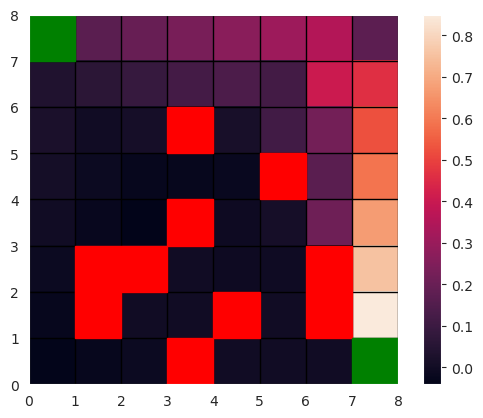

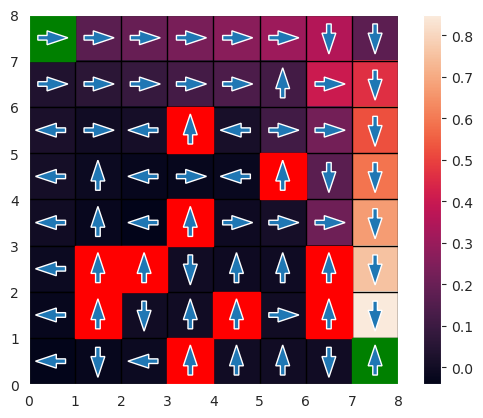

In [56]:
train(episodes=4000, td_num=1, lr=0.1, isSlippery=False, exploration_strategy="epsilon")

With deterministic env(no slippery) the agent successfully learned the optimal policy

Next we will test the td-learning with number of steps 5

__________________________________


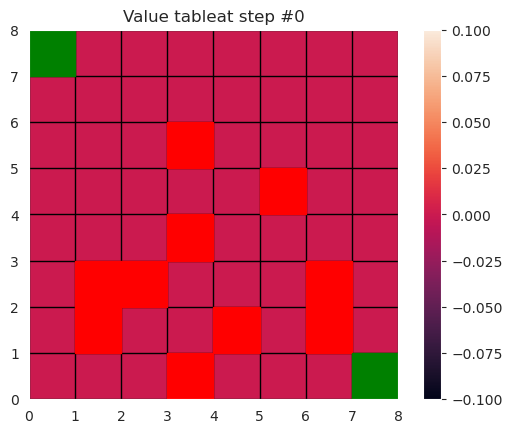

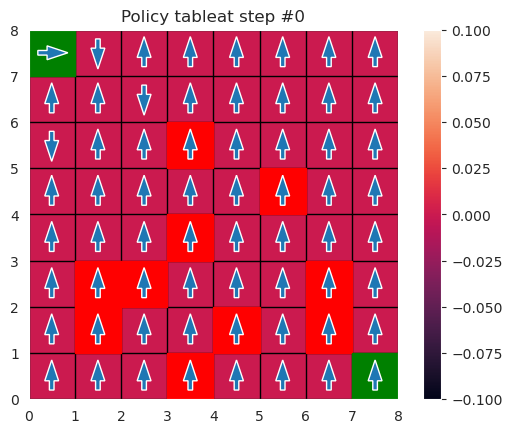

__________________________________


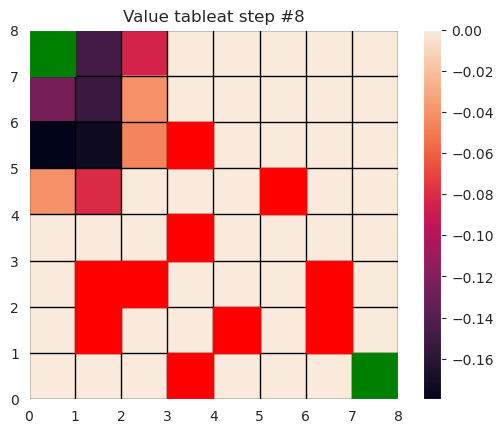

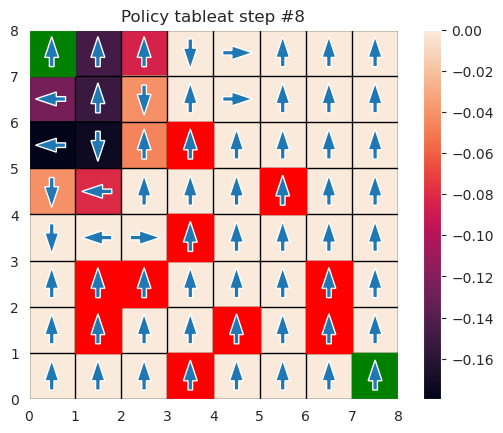

__________________________________


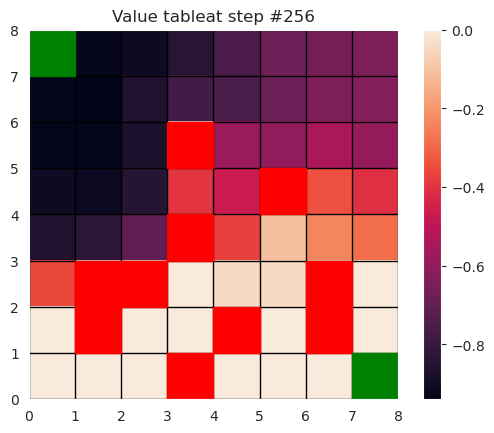

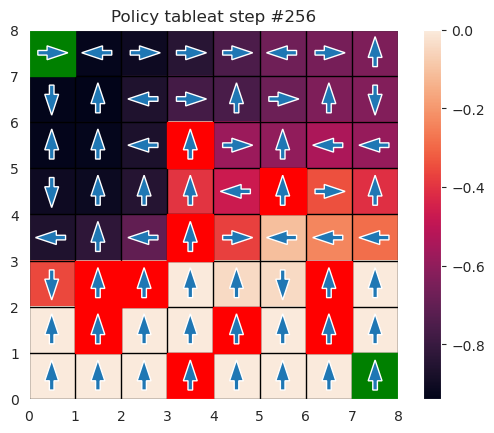

__________________________________


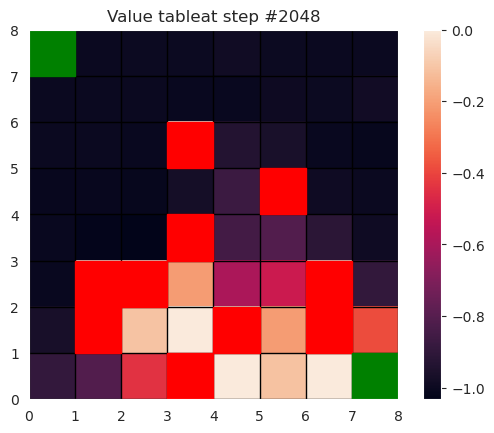

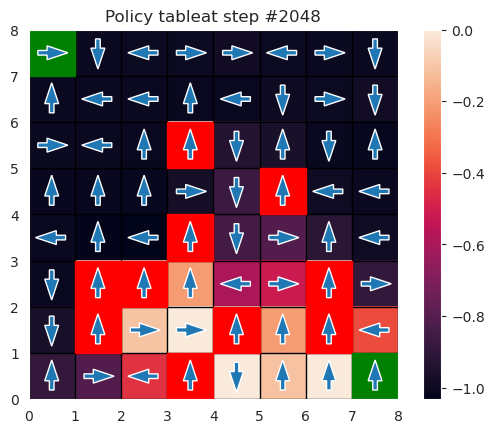

__________________________________


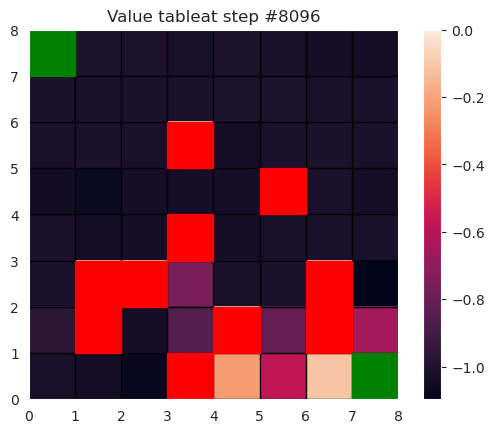

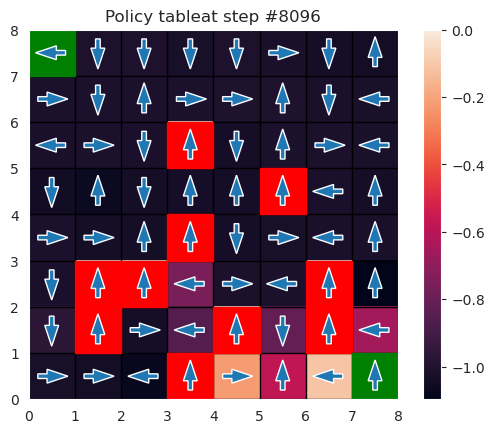

__________________________________
Learning curve


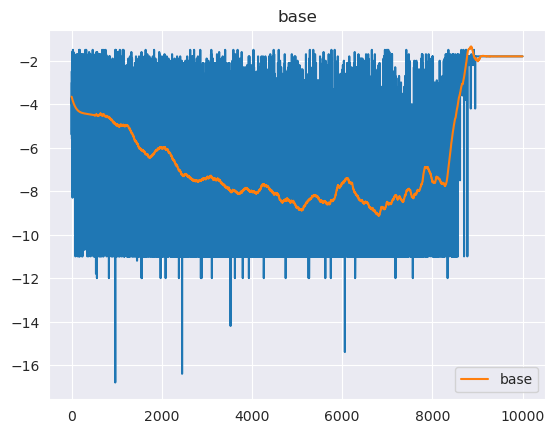

__________________________________
base
Mean reward: -1.8000000000000005
Mean success rate: 1.0
Mean steps per success episode: 14.0
__________________________________
Final Q_Table:


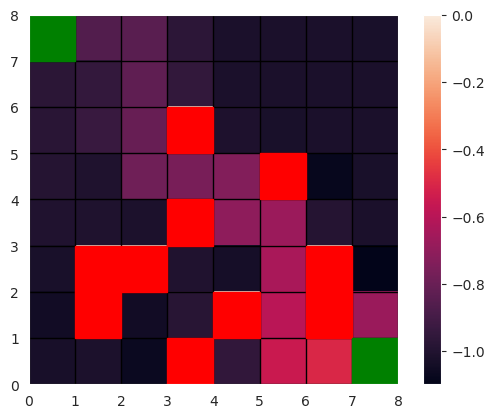

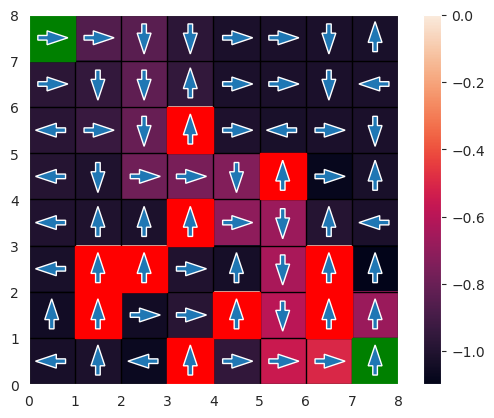

In [29]:
train(episodes=10000, td_num=5, lr=0.1, cost_of_living=0.1, isSlippery=False, draw_q_table=[0, 8, 256, 2048, 8096], truncated_penalty=1)

the temporal difference learning showed worse performance, mainly because the environment of the frozen lake is better for the one step update, since we care way less about doing strategy, we just need to understand which actions leads the agent to termination(falling into hole).

next will test the stochastic env by turning is slippery to true

__________________________________


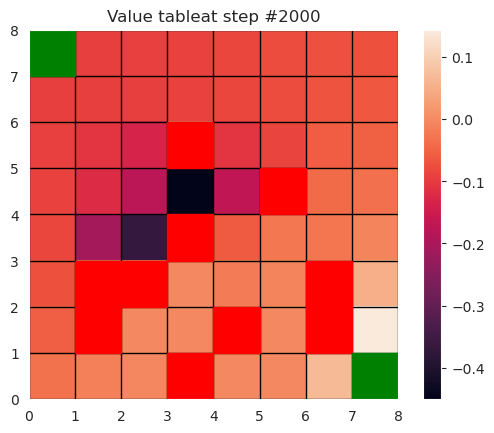

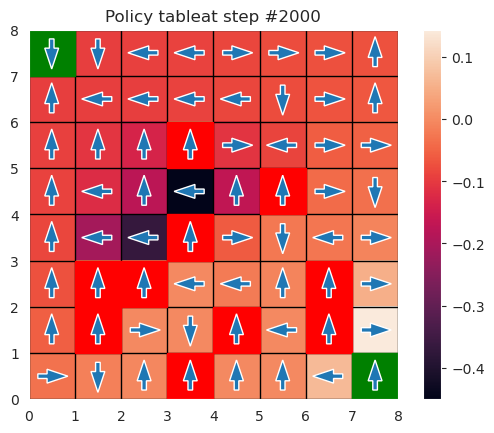

__________________________________


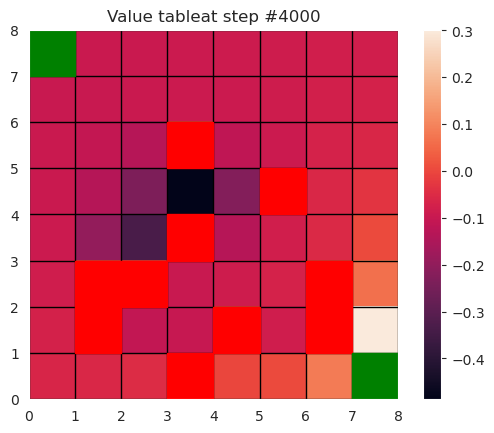

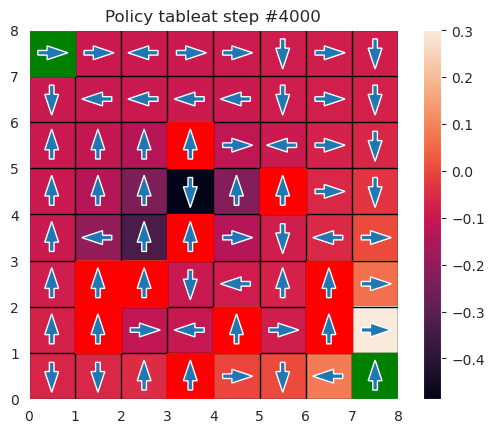

__________________________________


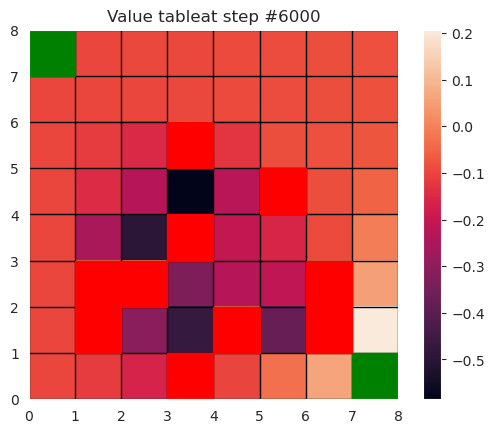

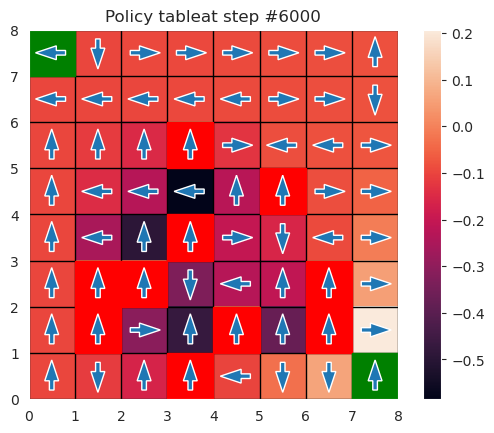

__________________________________


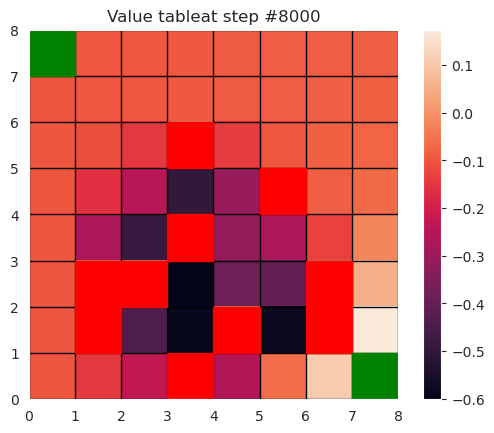

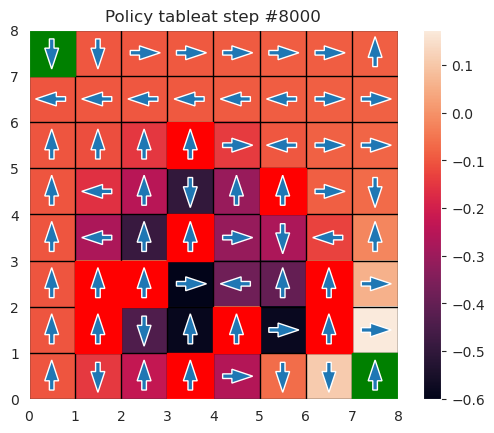

__________________________________
Learning curve


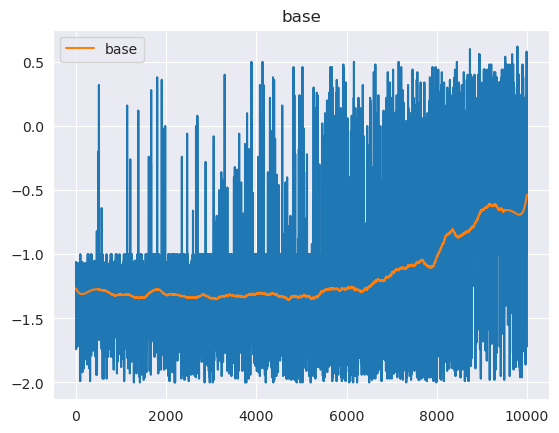

__________________________________
base
Mean reward: -0.6423400000000004
Mean success rate: 0.574
Mean steps per success episode: 63.93055555555556
__________________________________
Final Q_Table:


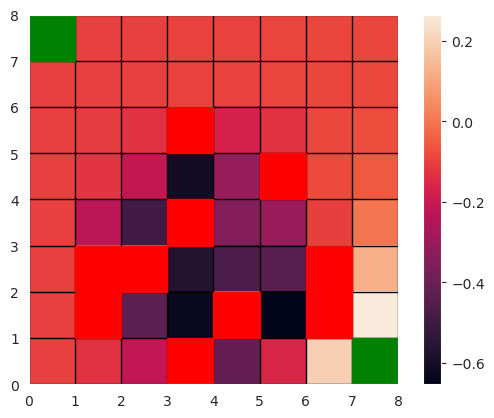

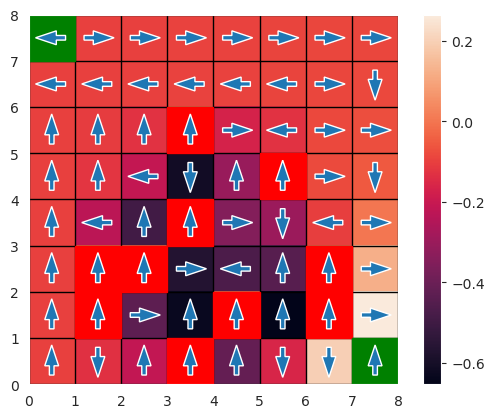

In [26]:
train(episodes=10000, td_num=1, lr=0.1, isSlippery=True, truncated_penalty=0)

test different learning rates

__________________________________
Learning curve
__________________________________
LR 0.0001
Mean reward: -1.2396200000000004
Mean success rate: 0.015
Mean steps per success episode: 56.42857142857143
__________________________________
Learning curve
__________________________________
LR 0.01
Mean reward: -1.0796800000000002
Mean success rate: 0.16
Mean steps per success episode: 61.285714285714285
__________________________________
Learning curve
__________________________________
LR 0.1
Mean reward: -0.6937800000000004
Mean success rate: 0.514
Mean steps per success episode: 63.6551724137931
__________________________________
Learning curve
__________________________________
LR 0.5
Mean reward: -0.7858600000000004
Mean success rate: 0.376
Mean steps per success episode: 69.04651162790698


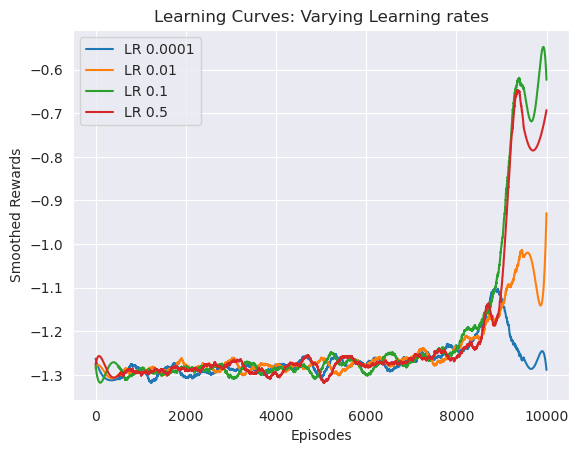

In [65]:
train(episodes=10000, lr=0.0001, label="LR 0.0001", render=False, exploration_strategy="epsilon", td_num= 1)
train(episodes=10000, lr=0.01, label="LR 0.01", render=False, exploration_strategy="epsilon", td_num= 1)
train(episodes=10000, lr=0.1, label="LR 0.1", render=False, exploration_strategy="epsilon", td_num= 1)
train(episodes=10000, lr=0.5, label="LR 0.5", render=False, exploration_strategy="epsilon", td_num= 1)

plt.title("Learning Curves: Varying Learning rates")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()


test boltzmann exploration

__________________________________
Learning curve
__________________________________
T=1
Mean reward: -0.7348900000000005
Mean success rate: 0.477
Mean steps per success episode: 67.31372549019608
__________________________________
Learning curve
__________________________________
T=2
Mean reward: -0.6983000000000004
Mean success rate: 0.491
Mean steps per success episode: 61.01960784313726
__________________________________
Learning curve
__________________________________
T=5
Mean reward: -0.6612400000000005
Mean success rate: 0.563
Mean steps per success episode: 66.96551724137932
__________________________________
Learning curve
__________________________________
T=10
Mean reward: -0.6867700000000004
Mean success rate: 0.514
Mean steps per success episode: 67.16981132075472


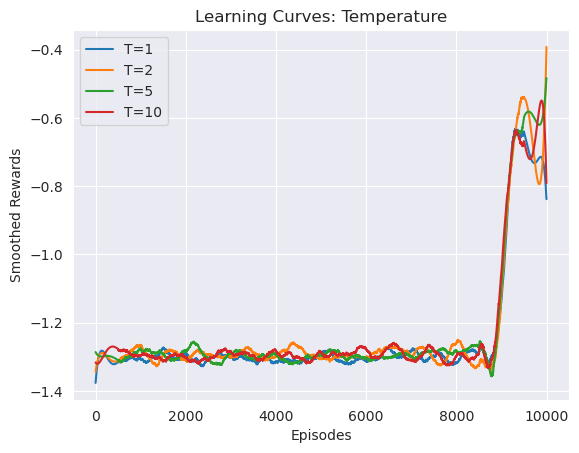

In [71]:
train(episodes=10000, lr=0.1, render=False, td_num=1, exploration_strategy="boltzmann", temperature=1, label="T=1")
train(episodes=10000, lr=0.1, render=False, td_num=1, exploration_strategy="boltzmann", temperature=2, label="T=2")
train(episodes=10000, lr=0.1, render=False, td_num=1, exploration_strategy="boltzmann", temperature=5, label="T=5")
train(episodes=10000, lr=0.1, render=False, td_num=1, exploration_strategy="boltzmann", temperature=10, label="T=10")

plt.title("Learning Curves: Temperature")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()

Training Boltzmann | td_num=1, lr=0.001
__________________________________
Learning curve
__________________________________
Boltzmann_td1_lr0.001
Mean reward: -1.1973450000000003
Mean success rate: 0.091
Mean steps per success episode: 65.9090909090909
Training Boltzmann | td_num=1, lr=0.05
__________________________________
Learning curve
__________________________________
Boltzmann_td1_lr0.05
Mean reward: -0.6503450000000005
Mean success rate: 0.565
Mean steps per success episode: 64.02586206896552
Training Boltzmann | td_num=1, lr=0.1
__________________________________
Learning curve
__________________________________
Boltzmann_td1_lr0.1
Mean reward: -0.6614800000000005
Mean success rate: 0.5345
Mean steps per success episode: 65.27927927927928
Training Boltzmann | td_num=1, lr=0.5
__________________________________
Learning curve
__________________________________
Boltzmann_td1_lr0.5
Mean reward: -0.8340000000000004
Mean success rate: 0.29
Mean steps per success episode: 70.354838

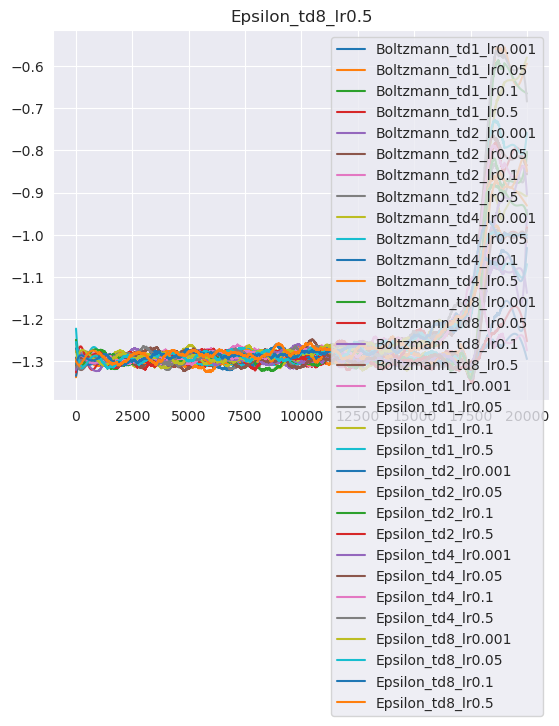

In [81]:
# Define benchmark settings
td_nums = [1, 2, 4, 8]
learning_rates = [1e-3, 5e-2, 1e-1, 5e-1]
episodes = 20000

# Store results
boltzmann_rewards = np.zeros((len(td_nums), len(learning_rates)))
epsilon_rewards = np.zeros((len(td_nums), len(learning_rates)))

# Run training for all combinations with actual train function
for i, td_num in enumerate(td_nums):
    for j, learning_rate in enumerate(learning_rates):
        print(f"Training Boltzmann | td_num={td_num}, lr={learning_rate}")
        mean_reward = train(
            episodes=episodes,
            lr=learning_rate,
            td_num=td_num,
            render=False,
            exploration_strategy="boltzmann",
            temperature=2,
            label=f"Boltzmann_td{td_num}_lr{learning_rate}"
        )
        boltzmann_rewards[i, j] = mean_reward

for i, td_num in enumerate(td_nums):
    for j, learning_rate in enumerate(learning_rates):
        print(f"Training Epsilon | td_num={td_num}, lr={learning_rate}")
        mean_reward = train(
            episodes=episodes,
            lr=learning_rate,
            td_num=td_num,
            render=False,
            exploration_strategy="epsilon",
            label=f"Epsilon_td{td_num}_lr{learning_rate}"
        )
        epsilon_rewards[i, j] = mean_reward

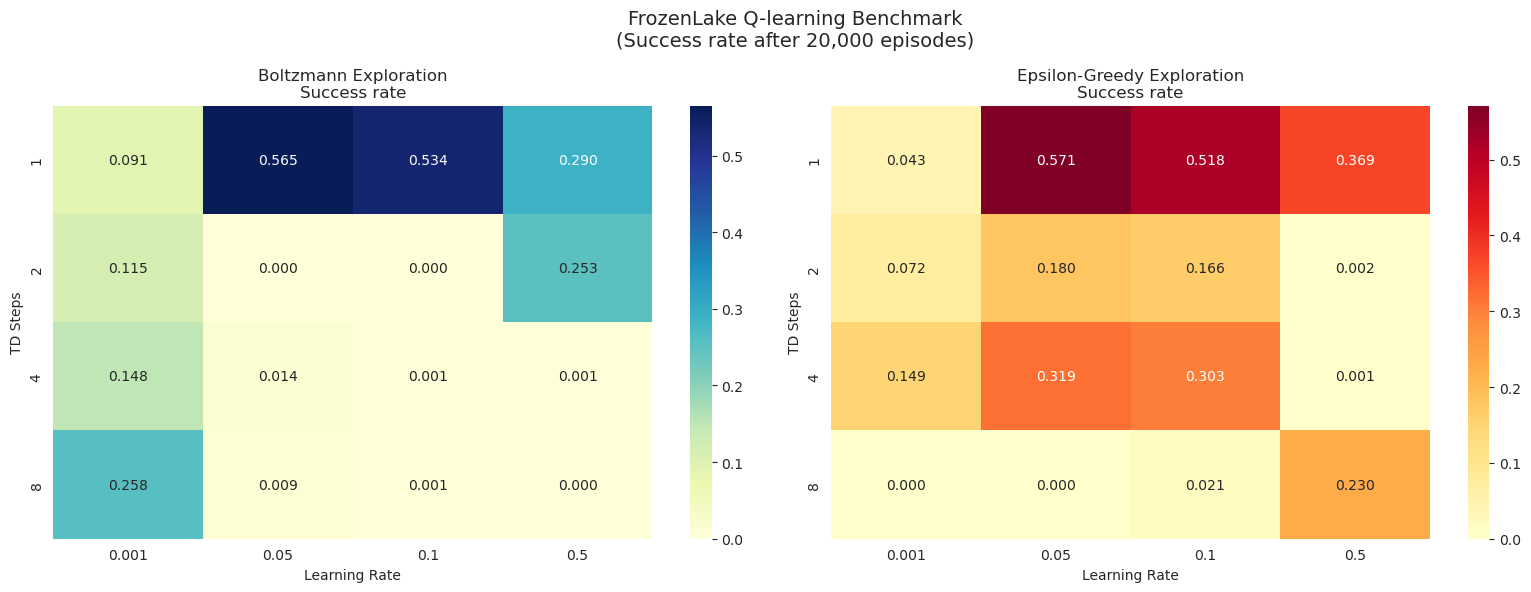

In [82]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    boltzmann_rewards,
    xticklabels=learning_rates,
    yticklabels=td_nums,
    cmap="YlGnBu",
    annot=True,
    fmt=".3f",
    ax=axes[0],
)
axes[0].set_title("Boltzmann Exploration\nSuccess rate")
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("TD Steps")

sns.heatmap(
    epsilon_rewards,
    xticklabels=learning_rates,
    yticklabels=td_nums,
    cmap="YlOrRd",
    annot=True,
    fmt=".3f",
    ax=axes[1],
)
axes[1].set_title("Epsilon-Greedy Exploration\nSuccess rate")
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("TD Steps")

plt.suptitle("FrozenLake Q-learning Benchmark\n(Success rate after 20,000 episodes)", fontsize=14)
plt.tight_layout()
plt.show()